# 1. Import Python libraries

In [1]:
import pickle 
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# 2. Load image labels
Now that we have imported all the necessary libraries, let's take a look at the labels for our data. We will load the labels.csv file into a DataFrame called "labels". The index of this DataFrame will correspond to the image ID (e.g. an index of 1036 refers to an image named 1036.jpg), and the "genus" column will tell us the bee type. The "genus" column will take a value of either 0.0 (for Apis or honey bee) or 1.0 (for Bombus or bumble bee).

In [2]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('datasets/labels.csv', index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels.genus.values

0.0    827
1.0    827
Name: genus, dtype: int64


Image has shape: (50, 50, 3)
RGB values for the top left pixel are: [107 111  97]


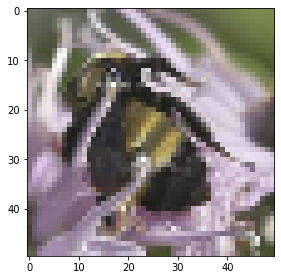

In [3]:
# load an image and explore
example_image = io.imread('datasets/{}.jpg'.format(labels.index[84])) 

# show image
plt.imshow(example_image)
# print shape
print('Image has shape:', example_image.shape)

# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0, 0, :])

## 4. Importing the image data

Now we will import all images. Once imported, we will stack the resulting arrays into a single matrix and assign it to X.

In [4]:
# create empty list
image_list = []

for i in labels.index:
    # load image
    img = io.imread('datasets/{}.jpg'.format(i)).astype(np.float64)
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


## 5. Split data into train, test, and evaluation sets
After obtaining the image data matrix, X, and its corresponding labels, y, it is necessary to split the data into train, test, and evaluation sets. Firstly, 20% of the data will be allocated to the evaluation set, which will be used to score the model after it is trained. This set is never seen by the model during the training phase.

The remaining data will be split into train and test sets with a 60/40 ratio, similar to what is done in supervised machine learning models. Both the train and test sets will be used in the neural network.

In [5]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim, 
                                                    y_interim, 
                                                    test_size=0.4, 
                                                    random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')


x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


## 6. Normalize image data
Normalization is the process of scaling data to ensure that all the features are on a similar scale. In this case, we want to normalize our image data to ensure that each feature has a consistent range, so that our neural network can learn effectively across all features. If some features have a much larger variance than others, they may dominate the objective function and prevent the network from learning from other features correctly.

To normalize our data, we will scale it so that it has a mean of 0 and a standard deviation of 1. We will use the StandardScaler class from the scikit-learn library to perform this operation. This will involve subtracting the mean from each value and dividing by the standard deviation. We will need to do this operation for each color channel, or feature, independently.

In [6]:
# initialize standard scaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim, x_eval)
scale_features(x_train, x_test)

## 7. Model building 
Normalization is the process of scaling data to ensure that all the features are on a similar scale. In this case, we want to normalize our image data to ensure that each feature has a consistent range, so that our neural network can learn effectively across all features. If some features have a much larger variance than others, they may dominate the objective function and prevent the network from learning from other features correctly.

To normalize our data, we will scale it so that it has a mean of 0 and a standard deviation of 1. We will use the StandardScaler class from the scikit-learn library to perform this operation. This will involve subtracting the mean from each value and dividing by the standard deviation. We will need to do this operation for each color channel, or feature, independently.

After the initial two convolutional layers, we need to add other layers that will contribute to the overall functionality of the network. The neural network architecture will include the following layers:

•	MaxPooling: This layer downscales the image by outputting the maximum value within a (2,2) moving window.

•	Conv2D: We add a third convolutional layer, which will enable the model to learn better features from images.

•	Dropout: This layer randomly sets 25% of the input units to zero during each training update to prevent overfitting.

•	Flatten: This layer flattens the output from the convolutional part of the CNN into a one-dimensional feature vector, which is passed into the following fully connected layers.

•	Dense: This is a fully connected layer, where every input is connected to every output.

•	Dropout: This is another dropout layer, but with a rate of 50%.

•	Dense: This final layer calculates the probability that the image is either a bumble bee or honey bee.

We'll print the model summary to take a closer look at the layers and their configurations.


In [7]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))


# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

## 8. Compile and train model
<p>Now that we've specified the model architecture, we will <a href="https://keras.io/models/model/#compile">compile</a> the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model).</p>
<p>Then, we'll call <a href="https://keras.io/models/model/#fit"><code>.fit</code></a> to begin the trainig the process. </p>
<blockquote>
  <p>"Neural networks are trained iteratively using optimization techniques like gradient descent. After each cycle of training, an error metric is calculated based on the difference between prediction and target…Each neuron’s coefficients (weights) are then adjusted relative to how much they contributed to the total error. This process is repeated iteratively." <a href="https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html">ML Cheatsheet</a></p>
</blockquote>
<p>Since training is computationally intensive, we'll do a 'mock' training to get the feel for it, using just the first 10 images in the train and test sets and training for just 5 epochs. Epochs refer to the number of iterations over the data. Typically, neural networks will train for hundreds if not thousands of epochs.</p>
<p>Take a look at the printout for each epoch and note the loss on the train set (<code>loss</code>), the accuracy on the train set (<code>acc</code>), and loss on the test set (<code>val_loss</code>) and the accuracy on the test set (<code>val_acc</code>). We'll explore this more in a later step.</p>

In [8]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
model.fit(
    x_train[:10, :, :, :],
    y_train[:10],
    epochs=5,
    verbose=1,
    validation_data=(x_test[:10, :, :, :], y_test[:10])
)

Epoch 1/5
1/1 [==============================] - 1s 988ms/step - loss: 0.7273 - accuracy: 0.3000 - val_loss: 0.7385 - val_accuracy: 0.4000
Epoch 2/5
1/1 [==============================] - 0s 60ms/step - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.7378 - val_accuracy: 0.4000
Epoch 3/5
1/1 [==============================] - 0s 60ms/step - loss: 0.7258 - accuracy: 0.4000 - val_loss: 0.7394 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 58ms/step - loss: 0.6883 - accuracy: 0.7000 - val_loss: 0.7421 - val_accuracy: 0.3000
Epoch 5/5
1/1 [==============================] - 0s 60ms/step - loss: 0.7439 - accuracy: 0.6000 - val_loss: 0.7433 - val_accuracy: 0.4000


## 9. Load pre-trained model and score
To compile and train the model, we need to specify the loss function, optimizer, and evaluation metric. For this task, we'll use the following:
•	Loss function: binary cross-entropy, since we're doing binary classification
•	Optimizer: Adam, a popular optimizer for neural networks
•	Evaluation metric: accuracy, to judge the performance of the model
We'll then call the fit method to start the training process. Since we're just doing a mock training with a small subset of the data, we'll use a batch size of 5 and train for only 5 epochs.

In [9]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('datasets/pretrained_model.h5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.6719561815261841
Test accuracy: 0.6188679337501526

Eval loss: 0.6701621413230896
Eval accuracy: 0.6374622583389282


## 10. Visualize model training history

We can visualize the history of the training process using the History object. The history object keeps track of the loss and accuracy for both the training and validation sets after each epoch.

In this case, we loaded the history object using the pickle library and plotted the training and validation accuracy and loss over time. The plot shows how the accuracy improves over time, eventually leveling off. The loss also decreases over time. Such plots can help diagnose overfitting. If the validation loss starts to increase after some point, it might indicate that the model has started to memorize the training set and is not generalizing well to new data.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


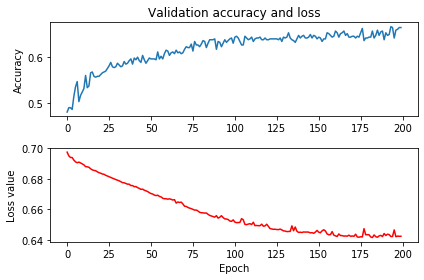

In [10]:
# load history
with open('datasets/model_history.pkl', 'rb') as f:
    pretrained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

## 11. Generate predictions

Previously, we calculated an overall score for our pre-trained model on the validation set. To end this notebook, let's access probabilities and class predictions for individual images using the .predict() method and np.round().

We now have a deep learning model that can be used to identify honey bees and bumble bees in images! The next step is to explore transfer learning, which harnesses the prediction power of models that have been trained on far more images than the mere 1600 in our dataset.

In [11]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
for i in range(5):
    if(y_pred[i]>0.5):
        print("this is a bumble bee")
    else:
        print("this is an honey bee")

First five probabilities:
[[0.5104395 ]
 [0.5508864 ]
 [0.6333447 ]
 [0.18111488]
 [0.33957684]]

First five class predictions:
this is a bumble bee
this is a bumble bee
this is a bumble bee
this is an honey bee
this is an honey bee
